In [ ]:


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from torchvision.models import resnet18
from torchvision.datasets import Caltech256
from torch.utils.data import random_split
from torchdata.datapipes.iter import IterableWrapper



In [ ]:
import os
root="./data"
class_names = sorted(os.listdir(root+"/caltech256/256_ObjectCategories"))
image_size = 128

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it


dataset = Caltech256(
    root=root,

    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
wanted_classes = ['063.electric-guitar-101', '250.zebra', '234.tweezer', '237.vcr', '249.yo-yo']
wanted_dataset = list(IterableWrapper(dataset).filter(lambda element: class_names[element[1]] in wanted_classes))
train_dataset, test_dataset = random_split(wanted_dataset, [.8, .2])

train_dataloader= torch.utils.data.DataLoader(train_dataset, batch_size=10,
                                            shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50,
                                            shuffle=False, num_workers=2)


Files already downloaded and verified


In [ ]:
net = resnet18(pretrained=True)

device = 'cpu'

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)


def accuracy(out, labels):

    _,pred = torch.max(out, dim=1)

    return torch.sum(pred==labels).item()


num_ftrs = net.fc.in_features

net.fc = nn.Linear(num_ftrs, 257) # 256 categories + 1 for unkown

# net.fc = net.fc.cuda() if device else net.fc

In [ ]:
import numpy as np
device = 'cpu'
n_epochs = 10

print_every = 20

valid_loss_min = np.Inf

val_loss = []

val_acc = []

train_loss = []

train_acc = []

total_step = int(len(train_dataloader))


for epoch in range(1, n_epochs+1):

    running_loss = 0.0

    correct = 0

    total=0

    print(f'Epoch {epoch}\n')

    for batch_idx, (data_, target_) in enumerate(train_dataloader):

        data_, target_ = data_.to(device), target_.to(device)

        optimizer.zero_grad()

        

        outputs = net(data_)

        loss = criterion(outputs, target_)

        loss.backward()

        optimizer.step()


        running_loss += loss.item()

        _,pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred==target_).item()

        total += target_.size(0)

        if (batch_idx) % 20 == 0:

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 

                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))

    train_acc.append(100 * correct / total)

    train_loss.append(running_loss/total_step)

    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    batch_loss = 0

    total_t=0

    correct_t=0

    with torch.no_grad():

        net.eval()

        for data_t, target_t in (test_dataloader):

            data_t, target_t = data_t.to(device), target_t.to(device)

            outputs_t = net(data_t)

            loss_t = criterion(outputs_t, target_t)

            batch_loss += loss_t.item()

            _,pred_t = torch.max(outputs_t, dim=1)

            correct_t += torch.sum(pred_t==target_t).item()

            total_t += target_t.size(0)

        val_acc.append(100 * correct_t/total_t)

        val_loss.append(batch_loss/len(test_dataloader))

        network_learned = batch_loss < valid_loss_min

        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


        

        if network_learned:

            valid_loss_min = batch_loss

            torch.save(net.state_dict(), 'resnet.pt')

            print('Improvement-Detected, save-model')

    net.train()

Epoch 1

Epoch [1/10], Step [0/43], Loss: 5.9275
Epoch [1/10], Step [20/43], Loss: 5.5588
Epoch [1/10], Step [40/43], Loss: 5.1384

train-loss: 5.6290, train-acc: 0.9434
validation loss: 5.4771, validation acc: 0.9434

Improvement-Detected, save-model
Epoch 2

Epoch [2/10], Step [0/43], Loss: 5.1584
Epoch [2/10], Step [20/43], Loss: 5.2118
Epoch [2/10], Step [40/43], Loss: 4.8067

train-loss: 5.3197, train-acc: 9.6698
validation loss: 5.0246, validation acc: 24.5283

Improvement-Detected, save-model
Epoch 3

Epoch [3/10], Step [0/43], Loss: 4.6458
Epoch [3/10], Step [20/43], Loss: 4.9955
Epoch [3/10], Step [40/43], Loss: 4.9388

train-loss: 5.0105, train-acc: 29.2453
validation loss: 4.7177, validation acc: 40.5660

Improvement-Detected, save-model
Epoch 4

Epoch [4/10], Step [0/43], Loss: 5.3227
Epoch [4/10], Step [20/43], Loss: 3.7556
Epoch [4/10], Step [40/43], Loss: 4.5997

train-loss: 4.7033, train-acc: 45.7547
validation loss: 4.4447, validation acc: 56.6038

Improvement-Detected

In [ ]:
for test_images, test_labels in test_dataloader: 
  example_scores = net(
  test_images
  ).detach()
  _, example_predicted_labels = torch.max(example_scores.data, 1)
  print(example_predicted_labels)
  break



tensor([ 62, 248, 236, 236,  62, 249, 236, 233, 236, 249, 233, 233, 249,  62,
        233,  62, 233, 248,  62, 233,  62,  62, 236, 236, 233, 248,  62, 233,
         62,  62,  62, 249, 233,  62, 233, 233,  62, 236, 236, 236,  62, 158,
        236, 248,  42, 236,  62, 249, 249, 248])


249.yo-yo
Prediction: 249.yo-yo


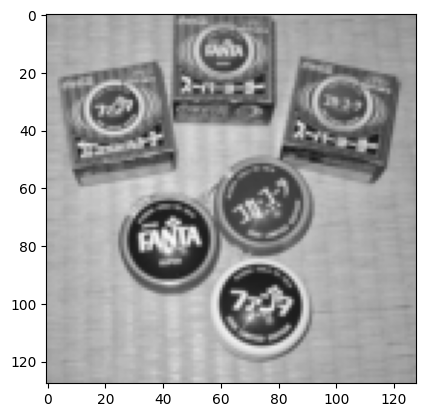

In [ ]:
from matplotlib import pyplot as plt
print(class_names[test_labels[1]])
plt.imshow(test_images[1].permute(1, 2, 0))
print(f"Prediction: {class_names[example_predicted_labels[1]]}")

# LIME TIME

In [ ]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sample_image_index = 2 # Change to test another image

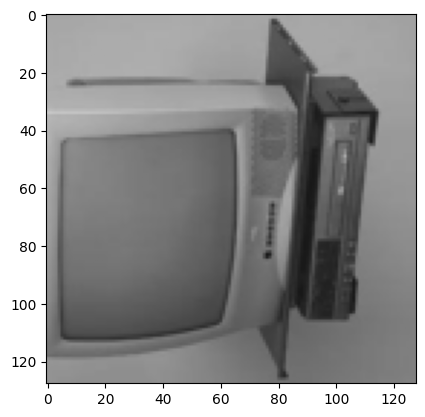

Prediction class: 237.vcr


  0%|          | 0/1000 [00:00<?, ?it/s]

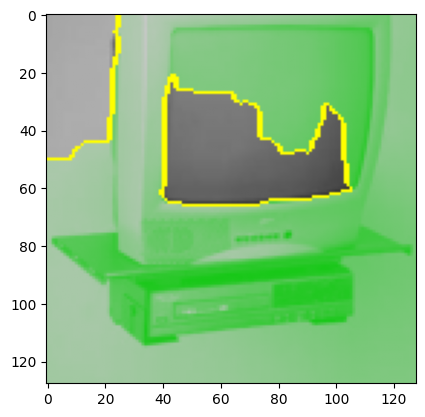

In [ ]:
img = test_dataset[sample_image_index][0]
plt.imshow(img.T)
plt.show()
import torch.nn.functional as F

net.eval()
logits = net(img.unsqueeze(0).cuda())

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().cpu().numpy(), probs5[1][0].detach().cpu().numpy()))

# Copied a bunch of these verbatim
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.ToPILImage()
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
def batch_predict(images):
    net.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    batch = batch.to(device)
    
    logits = net(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

test_pred = batch_predict([pill_transf(img)])
print(f"Prediction class: {class_names[test_pred.squeeze().argmax()]}")
import numpy as np
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
img

tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.